In [ ]:
"""
03_log_prediction.ipynb
"""

# Event log prediction

In [ ]:
### IMPORT ###
from pathlib import Path
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# AI
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional
from xgboost import XGBClassifier


### LOCAL IMPORT ###
from config import config_reader
from utilities import create_directories_with_gitkeep

In [489]:
### GLOBALS ###
yaml_config = config_reader.config_read_yaml("config.yml", "config")
# print(yaml_config) # debug
encoding_dir = str(yaml_config["ENCODING_DIR"])
csv_sep = ","

# INPUT
level = "PAGE" # PAGE, PARA
log_file = f"edu_event_log_{level}_raw_filtered_DISCO_ter_enr_no_SURVEY_P_{encoding_type}.csv" # The file filtered in the previous script (LEVEL to be replaced with prefix_type)

# Column (feature) names
id_variable = "Case ID" 
event_variable = "Activity"
timestamp_variable = "Complete Timestamp"

In [490]:
# INPUT

encoding_list = ["B", "F", "I"]
encoding_type = encoding_list[2] # <-- INPUT: set 0, 1 or 2 (from the list)

target_variable_list = ["UEQ - Overall_Tercile", "SUS_Tercile", "Apprendimento percepito_Tercile"]
target_variable = target_variable_list[0] # <-- INPUT: set 0, 1 or 2 to choose the target (from the list)

filed_notes_list = [0, 1] # 0 = no, 1 = yes
filed_notes = filed_notes_list[1] # <-- INPUT: set 0 or 1

In [491]:
# OUTPUT
ml_dir = str(yaml_config["ML_DIR"])
ml_file = str(yaml_config["ML_RES_FILE"])

## FUNCTIONS

In [492]:
def report_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns a report of columns with missing values in a dataframe.

    Parameters:
        df(pd.DataFrame): The input dataframe.

    Returns:
        pd.DataFrame: A dataframe with the count of missing values per column, sorted in descending order.
    """
    missing_values_report = df.isnull().sum()
    missing_values_report = missing_values_report[missing_values_report > 0]
    return missing_values_report.to_frame(name='Missing Values Count').sort_values(by='Missing Values Count', ascending=False)

In [493]:
def save_model_report(report_dict: dict, encoding_type: str, model_name: str, ml_dir: str, file_base_name: str, prediction_type: str, xls_file: bool) -> pd.DataFrame:
    """
    Saves a classification report as a CSV and optionally as an Excel file.

    This function converts the provided report dictionary into a pandas DataFrame, 
    formats it by inserting relevant metadata columns if missing, rounds key 
    performance metrics, and saves the resulting report to a specified directory. 

    Parameters:
        report_dict (dict): The classification report dictionary.
        encoding_type (str): The encoding type used in the model.
        model_name (str): The name of the machine learning model.
        ml_dir (str): The directory where the report files will be saved.
        file_base_name (str): The base name for the output file.
        prediction_type (str): The type of prediction task.
        xls_file (bool): Whether to save the report as an Excel file in addition to CSV.

    Returns:
        pd.DataFrame: The formatted classification report as a DataFrame.
    """
    # Convert the dictionary to a pandas DataFrame and transpose it for better readability
    df_report = pd.DataFrame(report_dict).transpose()
    # Prepare the classification report for final output
    if "Encoding" not in df_report.columns:
        df_report.insert(0, "Encoding", encoding_type)
    if "ModelName" not in df_report.columns:
        df_report.insert(1, "ModelName", model_name)
    if "FieldNotes" not in df_report.columns:
        df_report.insert(2, "FieldNotes", filed_notes)
    columns_to_round = ["precision", "recall", "f1-score"]
    for col in columns_to_round:
        if col in df_report.columns:
            df_report[col] = df_report[col].round(3)
    print("> Saving metrics")
    current_date_string = datetime.now().strftime("%Y-%m-%d")
    file_out = file_base_name.replace("MODEL", model_name)
    # CSV
    file_csv = f"{current_date_string}_{Path(file_out).stem}_{encoding_type}_{prediction_type}.csv"
    path_ml = Path(ml_dir) / file_csv
    print("Path:", path_ml)
    df_report.to_csv(path_ml, sep=";")
    # EXCEL
    if xls_file == True:
        sname = f"{model_name}_{encoding_type}"
        file_xls = f"{current_date_string}_{Path(file_out).stem}_{encoding_type}_{prediction_type}.xlsx"
        path_ml = Path(ml_dir) / file_xls
        df_report.to_excel(path_ml, sheet_name=sname)
    
    return df_report

In [494]:
def extract_feature_importances(pipeline: Pipeline, X_train: pd.DataFrame, ml_file: str, current_date_string: str, ml_dir: str, encoding_type: str, prediction_type:str) -> pd.DataFrame:
    """
    Extracts and saves feature importances from a classifier in a pipeline.
    
    This function retrieves the classifier from the provided pipeline,
    extracts its feature importances, and creates a DataFrame sorted in
    descending order of importance. It then saves the top 10 feature
    importances to a CSV file and plots the top 10 features.
    
    Args:
        pipeline (Pipeline): The pipeline containing the trained classifier.
        X_train (pd.DataFrame): The training data used for model fitting, with feature names.
        ml_file (str): The filename template from which to derive the output CSV filename.
        current_date_string (str): A string representing the current date, used in the output filename.
        ml_dir (Union[str, Path]): The directory where the CSV file will be saved.
        encoding_type (str): A string representing the encoding type, used in the output filename.
        encoding_type (str): A string representing the prediction type, standard or enriched.
        
    Returns:
        pd.DataFrame: A DataFrame containing the feature importances sorted in descending order.
    """

    top_n = 10 # <- INPUT

    # Extract the classifier from the pipeline using the 'named_steps' attribute.
    classifier_model = pipeline.named_steps['classifier']
    classifier_model_name = (classifier_model.__class__.__name__).replace("Classifier","")

    # Extract feature importances and the feature names from the training data.
    importances = classifier_model.feature_importances_
    feature_names = X_train.columns
    
    # Create a DataFrame with feature importances and sort it in descending order.
    feature_importances_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    # Display the feature importances DataFrame.
    print("Feature Importances:")
    print(feature_importances_df)
    
    # Save the top top_n feature importances to a CSV file.
    print("Saving feature importance")
    file_out = ml_file.replace("MODEL", classifier_model_name)
    file_out = f"{current_date_string}_{Path(file_out).stem}_{encoding_type}_{prediction_type}_fimp.csv"
    path_ml = Path(ml_dir) / file_out
    print("Path:", path_ml)
    feature_importances_df.head(top_n).to_csv(path_ml, sep=";")
    
    # Plot the top top_n feature importances.
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importances_df['Feature'][:top_n], feature_importances_df['Importance'][:top_n])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt_title = f"Top {top_n} Feature Importances from {classifier_model_name}"
    plt.title(plt_title)
    plt.gca().invert_yaxis()  # Reverse the order for better readability.
    plt.show()
    
    return feature_importances_df

In [530]:

def aggregate_csv_results(folder_path: str, extension: str, exclude_str: str, csv_sep: str = ";") -> pd.DataFrame:
    """
    Aggregates CSV files in a given folder by:
      - Selecting files with the specified extension (excluding those whose names contain a given string).
      - Reading each CSV into a DataFrame.
      - For each DataFrame, taking the first three rows (rows 0, 1 and 2) and grouping by
        'ModelName', 'Encoding' and 'FieldNotes'. Then computing the mean values for the
        columns 'precision', 'recall' and 'f1-score'.
      - Combining all the per-file summaries into one final DataFrame with columns:
        'ModelName', 'FieldNotes', 'Encoding', 'Avg precision', 'Avg recall' and 'Avg f1-score'.
    
    Args:
      folder_path (str): The path to the folder containing the files.
      extension (str): The file extension to consider (e.g. '.csv').
      exclude_str (str): A string; files whose names contain this string will be ignored.
      csv_sep (str): the CSV separator
      
    Returns:
      pd.DataFrame: A DataFrame with one row per unique combination of ModelName, FieldNotes and Encoding,
                    containing the average metrics.
    """
    
    folder = Path(folder_path)
    summaries = []
    
    files_count = 0

    # Iterate over all files matching the pattern "*{extension}" in the folder
    for file_path in folder.glob("*" + extension):
        # Skip file if its name contains the exclusion string
        if exclude_str in file_path.name:
            continue
        
        try:
            # Read the CSV into a DataFrame
            df = pd.read_csv(file_path, sep=csv_sep)
        except Exception as e:
            print(f"Error reading {file_path.name}: {e}")
            continue
        
        files_count+=1

        # Check that the required columns are present in the CSV
        required_cols = {'ModelName', 'Encoding', 'FieldNotes', 'precision', 'recall', 'f1-score'}
        if not required_cols.issubset(df.columns):
            print(f"File {file_path.name} does not contain the required columns.")
            continue
        
        # Select only the first three rows (rows 0, 1 and 2)
        df_subset = df.head(3)
        
        # Group by 'ModelName', 'Encoding' and 'FieldNotes' and calculate mean values for the metric columns
        group_means = (
            df_subset
            .groupby(['ModelName', 'Encoding', 'FieldNotes'])[['precision', 'recall', 'f1-score']]
            .mean()
            .reset_index()
        )
        
        # Rename the metric columns to reflect that these are average values
        group_means.rename(columns={
            'precision': 'Avg precision',
            'recall': 'Avg recall',
            'f1-score': 'Avg f1-score'
        }, inplace=True)
        
        summaries.append(group_means)
    
    # Combine all per-file summaries into one DataFrame.
    if summaries:
        combined_df = pd.concat(summaries, ignore_index=True)
        final_df = (
            combined_df
            .groupby(['ModelName', 'Encoding', 'FieldNotes'], as_index=False)
            .mean()
        )
        # Reorder the columns as specified: ModelName, FieldNotes, Encoding, Avg precision, Avg recall, Avg f1-score
        final_df = final_df[['ModelName', 'FieldNotes', 'Encoding', 'Avg precision', 'Avg recall', 'Avg f1-score']]
        final_df[['Avg precision', 'Avg recall', 'Avg f1-score']] = final_df[['Avg precision', 'Avg recall', 'Avg f1-score']].round(3)
        final_df = final_df.sort_values(by=["Avg f1-score"], ascending=False)
    else:
        # Return an empty DataFrame with the required columns if no files were processed
        final_df = pd.DataFrame(columns=['ModelName', 'FieldNotes', 'Encoding', 'Avg precision', 'Avg recall', 'Avg f1-score'])
    

    print(f"Files with extension '{extension}' read: {files_count}")
    print()
    print("Final dataset length:", len(final_df))
    print()

    return final_df

## MAIN

In [496]:
print()
print("*** PROGRAM START ***")
print()


*** PROGRAM START ***



In [497]:
start_time = datetime.now().replace(microsecond=0)
print("Start process:", str(start_time))
print()

Start process: 2025-02-08 14:59:33



In [498]:
print(">> Settings")
list_files = []
print("CSV separator:", csv_sep)
print(f"Input file: {log_file}")
print("Target variable:", target_variable)
print("Filed notes:", filed_notes)
current_date_string = datetime.now().strftime("%Y-%m-%d")

>> Settings
CSV separator: ,
Input file: edu_event_log_PAGE_raw_filtered_DISCO_ter_enr_no_SURVEY_P_F.csv
Target variable: UEQ - Overall_Tercile
Filed notes: 1


In [499]:
print(">> Creating output directories")
dir_output = []
dir_output.append(ml_dir)
create_directories_with_gitkeep(dir_output)

>> Creating output directories
Directory 'data_ml' and .gitkeep file created


In [500]:
print(">> Reading event log")
list_df_p = [] # dataframe container with event logs
# Column (feature) types
dic_t = {id_variable:object}
print("Input event log column types:", dic_t)
path_log_file = Path(encoding_dir) / log_file
print(f"Input file: {path_log_file}")
df_log_p = pd.read_csv(path_log_file, dtype=dic_t, sep=csv_sep, low_memory=False)

>> Reading event log
Input event log column types: {'Case ID': <class 'object'>}
Input file: data_encoding/edu_event_log_PAGE_raw_filtered_DISCO_ter_enr_no_SURVEY_P_F.csv


In [501]:
df_log_p.columns

Index(['Case ID', 'Complete Timestamp', 'click_num', 'dbclick_num',
       'QuizSessionCount_P3', 'QuizAnswerCorrectTotal_P3',
       'QuizAnswerWrongTotal_P3', 'QuizAnswerCorrectRatioOverCount_P3',
       'QuizAnswerCorrectRatioOverAll_P3', 'SUS_Tercile',
       'Apprendimento percepito_Tercile', 'Class_Count', 'FN_N', 'FN_Q',
       'FN_A', 'FN_C', 'FN_I', 'A_Time_s', 'A_Time_m', 'Forward_Jumps',
       'Backward_Jumps', 'Activity_INTRO', 'Activity_INTRO-Q', 'Activity_PROG',
       'Activity_PROG-Q', 'Activity_VARS', 'Activity_VARS-Q',
       'pageTitle_INTRO', 'pageTitle_INTRO-Q', 'pageTitle_PROG',
       'pageTitle_PROG-Q', 'pageTitle_VARS', 'pageTitle_VARS-Q', 'Class_ECO',
       'Class_SAA', 'Class_SMCN1', 'Class_SMCN2', 'Class_SMTO1', 'Class_SMTO2',
       'Class_SMTO3', 'FN_CT_FA', 'FN_CT_L', 'FN_CT_M', 'FN_CT_SA',
       'UEQ - Overall_Tercile'],
      dtype='object')

In [502]:
df_log_p.dtypes

Case ID                                object
Complete Timestamp                     object
click_num                               int64
dbclick_num                             int64
QuizSessionCount_P3                   float64
QuizAnswerCorrectTotal_P3             float64
QuizAnswerWrongTotal_P3               float64
QuizAnswerCorrectRatioOverCount_P3    float64
QuizAnswerCorrectRatioOverAll_P3      float64
SUS_Tercile                             int64
Apprendimento percepito_Tercile         int64
Class_Count                           float64
FN_N                                  float64
FN_Q                                  float64
FN_A                                  float64
FN_C                                  float64
FN_I                                  float64
A_Time_s                              float64
A_Time_m                              float64
Forward_Jumps                           int64
Backward_Jumps                          int64
Activity_INTRO                    

In [503]:
print("Dataframe shape before cleaning:", df_log_p.shape)

Dataframe shape before cleaning: (2260, 45)


### Checking and Cleaning the event log before prediction

In [504]:
print("> Removing columns not neede")
list_drop = [id_variable, timestamp_variable, target_variable_list[1], target_variable_list[2], "A_Time_m"] # <-- INPUT
# Filter only columns that exist in the dataframe
columns_to_drop = [col for col in list_drop if col in df_log_p.columns]
print(columns_to_drop)
df_log_p_clean = df_log_p.drop(columns=columns_to_drop)
print("Dataframe shape before cleaning:", df_log_p_clean.shape)

> Removing columns not neede
['Case ID', 'Complete Timestamp', 'SUS_Tercile', 'Apprendimento percepito_Tercile', 'A_Time_m']
Dataframe shape before cleaning: (2260, 40)


In [505]:
print("> Checking missing values")
missing_values_per_column = df_log_p_clean.isnull().sum().sort_values(ascending=False)
missing_values_per_column

> Checking missing values


QuizSessionCount_P3                   13
QuizAnswerCorrectTotal_P3             13
QuizAnswerWrongTotal_P3               13
QuizAnswerCorrectRatioOverCount_P3    13
QuizAnswerCorrectRatioOverAll_P3      13
FN_I                                   1
FN_Q                                   1
FN_C                                   1
FN_A                                   1
FN_N                                   1
Class_Count                            1
Class_SMTO2                            0
Class_ECO                              0
Class_SAA                              0
Class_SMCN1                            0
Class_SMCN2                            0
Class_SMTO1                            0
click_num                              0
Class_SMTO3                            0
FN_CT_FA                               0
FN_CT_L                                0
FN_CT_M                                0
FN_CT_SA                               0
pageTitle_VARS                         0
pageTitle_VARS-Q

In [506]:
print("> Fixing missing values")
columns_with_missing_values = df_log_p_clean.columns[df_log_p_clean.isnull().sum() > 0].tolist()

# Fill missing values with median in specific columns
for column in columns_with_missing_values:
    print("Fixing columns:", column)
    median_value = df_log_p_clean[column].median()
    df_log_p_clean[column] = df_log_p_clean[column].fillna(median_value)

> Fixing missing values
Fixing columns: QuizSessionCount_P3
Fixing columns: QuizAnswerCorrectTotal_P3
Fixing columns: QuizAnswerWrongTotal_P3
Fixing columns: QuizAnswerCorrectRatioOverCount_P3
Fixing columns: QuizAnswerCorrectRatioOverAll_P3
Fixing columns: Class_Count
Fixing columns: FN_N
Fixing columns: FN_Q
Fixing columns: FN_A
Fixing columns: FN_C
Fixing columns: FN_I


In [507]:
missing_values_per_column = df_log_p_clean.isnull().sum().sort_values(ascending=False)
missing_values_per_column

click_num                             0
dbclick_num                           0
pageTitle_INTRO                       0
pageTitle_INTRO-Q                     0
pageTitle_PROG                        0
pageTitle_PROG-Q                      0
pageTitle_VARS                        0
pageTitle_VARS-Q                      0
Class_ECO                             0
Class_SAA                             0
Class_SMCN1                           0
Class_SMCN2                           0
Class_SMTO1                           0
Class_SMTO2                           0
Class_SMTO3                           0
FN_CT_FA                              0
FN_CT_L                               0
FN_CT_M                               0
FN_CT_SA                              0
Activity_VARS-Q                       0
Activity_VARS                         0
Activity_PROG-Q                       0
FN_Q                                  0
QuizSessionCount_P3                   0
QuizAnswerCorrectTotal_P3             0


## Distribution of the target variable

In [508]:
print(">> Target variable")
print("Feature (column) name:", target_variable)
print("Distinct values:", df_log_p_clean[target_variable].unique().tolist())

>> Target variable
Feature (column) name: UEQ - Overall_Tercile
Distinct values: [1, 3, 2]


In [509]:
# Check if any feature is highly correlated with the target (do not consider target_variable since it's not yet removed)
correlation = df_log_p_clean.corr()[target_variable].abs().sort_values(ascending=False)
print(correlation)

UEQ - Overall_Tercile                 1.000000
QuizAnswerWrongTotal_P3               0.163371
QuizAnswerCorrectRatioOverCount_P3    0.162295
Class_SAA                             0.158936
FN_N                                  0.154423
FN_A                                  0.147416
Class_SMCN2                           0.138484
QuizAnswerCorrectTotal_P3             0.123577
QuizAnswerCorrectRatioOverAll_P3      0.123348
FN_Q                                  0.114134
FN_CT_FA                              0.110878
FN_I                                  0.101979
Class_SMTO3                           0.088346
QuizSessionCount_P3                   0.081654
Class_ECO                             0.074209
FN_CT_SA                              0.074209
click_num                             0.058211
Activity_VARS-Q                       0.056833
FN_CT_M                               0.053257
Class_SMTO1                           0.053257
dbclick_num                           0.035769
FN_C         

## Creating a dataframe with and without field notes (FN)

In [510]:
print("> Removing feature (column) for ml comparison")

df_log_p_with_fn = df_log_p_clean.copy()

# Define the list of columns to remove
cols_to_drop = [col for col in df_log_p_clean.columns if col.startswith('FN_')]

# Remove columns from df_log_clean if they exist
df_log_p_without_fn = df_log_p_clean.drop(columns=cols_to_drop)

> Removing feature (column) for ml comparison


In [511]:
df_log_p_with_fn.columns

Index(['click_num', 'dbclick_num', 'QuizSessionCount_P3',
       'QuizAnswerCorrectTotal_P3', 'QuizAnswerWrongTotal_P3',
       'QuizAnswerCorrectRatioOverCount_P3',
       'QuizAnswerCorrectRatioOverAll_P3', 'Class_Count', 'FN_N', 'FN_Q',
       'FN_A', 'FN_C', 'FN_I', 'A_Time_s', 'Forward_Jumps', 'Backward_Jumps',
       'Activity_INTRO', 'Activity_INTRO-Q', 'Activity_PROG',
       'Activity_PROG-Q', 'Activity_VARS', 'Activity_VARS-Q',
       'pageTitle_INTRO', 'pageTitle_INTRO-Q', 'pageTitle_PROG',
       'pageTitle_PROG-Q', 'pageTitle_VARS', 'pageTitle_VARS-Q', 'Class_ECO',
       'Class_SAA', 'Class_SMCN1', 'Class_SMCN2', 'Class_SMTO1', 'Class_SMTO2',
       'Class_SMTO3', 'FN_CT_FA', 'FN_CT_L', 'FN_CT_M', 'FN_CT_SA',
       'UEQ - Overall_Tercile'],
      dtype='object')

In [512]:
df_log_p_without_fn.columns

Index(['click_num', 'dbclick_num', 'QuizSessionCount_P3',
       'QuizAnswerCorrectTotal_P3', 'QuizAnswerWrongTotal_P3',
       'QuizAnswerCorrectRatioOverCount_P3',
       'QuizAnswerCorrectRatioOverAll_P3', 'Class_Count', 'A_Time_s',
       'Forward_Jumps', 'Backward_Jumps', 'Activity_INTRO', 'Activity_INTRO-Q',
       'Activity_PROG', 'Activity_PROG-Q', 'Activity_VARS', 'Activity_VARS-Q',
       'pageTitle_INTRO', 'pageTitle_INTRO-Q', 'pageTitle_PROG',
       'pageTitle_PROG-Q', 'pageTitle_VARS', 'pageTitle_VARS-Q', 'Class_ECO',
       'Class_SAA', 'Class_SMCN1', 'Class_SMCN2', 'Class_SMTO1', 'Class_SMTO2',
       'Class_SMTO3', 'UEQ - Overall_Tercile'],
      dtype='object')

In [513]:
# From here on, the two datasets to be used will be df_log_p_with_fn and df_log_p_withouth_fn

In [514]:
df_prediction = None
prediction_type = None
if filed_notes == 0:
    print("Prediction ")
    df_prediction = df_log_p_without_fn.copy()
    prediction_type = "STD"
else:
    df_prediction = df_log_p_with_fn.copy()
    prediction_type = "ENR"

## Machine Learning predictions

### Common data preparation

In [515]:
# Separate features (X) and target variable (y)
X = df_prediction.drop(columns=[target_variable]) # common for all models

# Verify that the target variable is not in the features
assert target_variable not in X.columns, "Target variable found in training features!"

### Random Forest

In [516]:
# Labels (for RF)
y = df_prediction[target_variable]

In [517]:
# -------------------------------------
# Data Splitting: Create training, validation, and test sets.
# -------------------------------------
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

# -------------------------------------
# Create a pipeline with a StandardScaler and a RandomForestClassifier.
# -------------------------------------
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Use StratifiedKFold for cross-validation (to maintain class balance)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# -------------------------------------
# Define the Hyperopt search space.
# We use hp.quniform for numerical parameters and hp.choice for categorical choices.
# -------------------------------------
space = {
    'classifier__n_estimators': hp.quniform('classifier__n_estimators', 50, 200, 10),
    'classifier__max_depth': hp.choice('classifier__max_depth', [None] + list(range(5, 21))),
    'classifier__min_samples_split': hp.quniform('classifier__min_samples_split', 2, 10, 1),
    'classifier__min_samples_leaf': hp.quniform('classifier__min_samples_leaf', 1, 5, 1)
}

# -------------------------------------
# Define the objective function for Hyperopt.
# This function sets the hyperparameters in the pipeline, performs cross-validation,
# and returns the negative mean accuracy as the loss.
# -------------------------------------
def objective(params):
    # Convert parameters from hp.quniform to integers.
    params['classifier__n_estimators'] = int(params['classifier__n_estimators'])
    params['classifier__min_samples_split'] = int(params['classifier__min_samples_split'])
    params['classifier__min_samples_leaf'] = int(params['classifier__min_samples_leaf'])
    
    # Set the parameters in the pipeline.
    pipeline.set_params(**params)
    
    # Evaluate the model using cross-validation.
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='accuracy')
    mean_score = sum(cv_scores) / len(cv_scores)
    
    # Return the negative mean score as the loss (since Hyperopt minimises the objective).
    return {'loss': -mean_score, 'status': STATUS_OK}

# -------------------------------------
# Run Hyperopt optimisation.
# -------------------------------------
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,  # Adjust the number of evaluations to balance computation time and search depth.
    trials=trials
)

# Process the best hyperparameters.
best_params = {
    'classifier__n_estimators': int(best['classifier__n_estimators']),
    'classifier__max_depth': best['classifier__max_depth'],  # Already the selected option from hp.choice.
    'classifier__min_samples_split': int(best['classifier__min_samples_split']),
    'classifier__min_samples_leaf': int(best['classifier__min_samples_leaf'])
}
print("Best hyperparameters found:", best_params)

# -------------------------------------
# Train the pipeline with the optimised hyperparameters.
# -------------------------------------
pipeline.set_params(**best_params)
pipeline.fit(X_train, y_train)

# Evaluate on the validation set.
y_val_pred = pipeline.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Optionally, evaluate using cross-validation on the training set.
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='accuracy')
mean_cv = sum(cv_scores) / len(cv_scores)
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", mean_cv)

# Finally, evaluate on the test set.
y_test_pred = pipeline.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# Save the classification_report of the test evaluation
report_dict = classification_report(y_test, y_test_pred, output_dict=True)

# Save the classification_report as file
# Extract the classifier from the pipeline using the 'named_steps' attribute.
classifier_model = pipeline.named_steps['classifier']
classifier_model_name = (classifier_model.__class__.__name__).replace('Classifier', '')
print("> Creating report metrics dataframe")
df_report = save_model_report(report_dict, encoding_type, classifier_model_name, ml_dir, ml_file, prediction_type, False)

100%|██████████| 50/50 [00:25<00:00,  1.95trial/s, best loss: -0.6640316205533596]
Best hyperparameters found: {'classifier__n_estimators': 80, 'classifier__max_depth': 16, 'classifier__min_samples_split': 4, 'classifier__min_samples_leaf': 1}
Validation Accuracy: 0.7066246056782335
Validation Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.77      0.71       115
           2       0.76      0.73      0.74       115
           3       0.70      0.60      0.65        87

    accuracy                           0.71       317
   macro avg       0.71      0.70      0.70       317
weighted avg       0.71      0.71      0.71       317

Cross-Validation Scores: [0.65612648 0.62055336 0.67588933 0.71936759 0.65612648]
Mean Cross-Validation Score: 0.6656126482213438
Test Accuracy: 0.700589970501475
Test Classification Report:
              precision    recall  f1-score   support

           1       0.71      0.77      0.74       246
 

>> XAI - Eplaining the model
Feature Importances:
                               Feature  Importance
0                            click_num    0.166064
13                            A_Time_s    0.144465
15                      Backward_Jumps    0.121294
14                       Forward_Jumps    0.079175
1                          dbclick_num    0.051284
16                      Activity_INTRO    0.033851
18                       Activity_PROG    0.025731
3            QuizAnswerCorrectTotal_P3    0.024209
17                    Activity_INTRO-Q    0.023018
6     QuizAnswerCorrectRatioOverAll_P3    0.022476
7                          Class_Count    0.022410
5   QuizAnswerCorrectRatioOverCount_P3    0.021979
4              QuizAnswerWrongTotal_P3    0.021906
20                       Activity_VARS    0.020822
19                     Activity_PROG-Q    0.015100
21                     Activity_VARS-Q    0.013313
2                  QuizSessionCount_P3    0.011249
24                      pageTitl

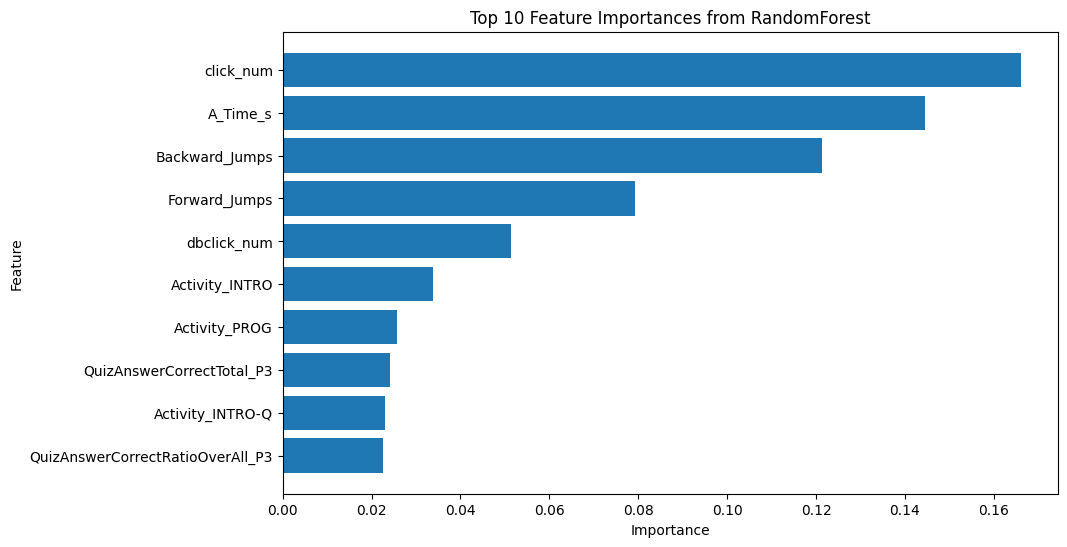

,Feature,Importance
0,click_num,0.166064
13,A_Time_s,0.144465
15,Backward_Jumps,0.121294
14,Forward_Jumps,0.079175
1,dbclick_num,0.051284
16,Activity_INTRO,0.033851
18,Activity_PROG,0.025731
3,QuizAnswerCorrectTotal_P3,0.024209
17,Activity_INTRO-Q,0.023018
6,QuizAnswerCorrectRatioOverAll_P3,0.022476


In [518]:
# XAI
print(">> XAI - Eplaining the model")
feature_importances_df = extract_feature_importances(pipeline, X_train, ml_file, current_date_string, ml_dir, encoding_type, prediction_type)
feature_importances_df.head(10)

### XGBoost

In [519]:
# Convert the target labels to start from 0 instead of 1 (LSTM and XGB starts from 0)
# (i.e. if your original labels are 1,2,3, they become 0,1,2)
y = df_prediction[target_variable] - 1

In [520]:
# -------------------------------------
# Data Splitting: Create training, validation, and test sets.
# -------------------------------------
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

# -------------------------------------
# Create a pipeline with a StandardScaler and an XGBClassifier.
# Note: 'use_label_encoder=False' and 'eval_metric' are set to avoid warnings.
# -------------------------------------
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

# Use StratifiedKFold for cross-validation (to maintain class balance)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# -------------------------------------
# Define the Hyperopt search space for XGBoost parameters.
# -------------------------------------
space = {
    'classifier__n_estimators': hp.quniform('classifier__n_estimators', 50, 300, 10),
    'classifier__max_depth': hp.choice('classifier__max_depth', list(range(3, 11))),  # Depth from 3 to 10
    'classifier__learning_rate': hp.loguniform('classifier__learning_rate', -3, 0)      # Learning rate between exp(-3) and 1
}

# -------------------------------------
# Define the objective function for Hyperopt.
# This function sets the hyperparameters in the pipeline, performs cross-validation,
# and returns the negative mean accuracy as the loss.
# -------------------------------------
def objective(params):
    # Convert hyperparameters to the appropriate type.
    params['classifier__n_estimators'] = int(params['classifier__n_estimators'])
    params['classifier__max_depth'] = int(params['classifier__max_depth'])
    # 'learning_rate' remains a float.
    
    # Set these parameters in the pipeline.
    pipeline.set_params(**params)
    
    # Evaluate the model using cross-validation.
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='accuracy')
    mean_score = sum(cv_scores) / len(cv_scores)
    
    # Return the negative mean score as the loss (since Hyperopt minimises the objective).
    return {'loss': -mean_score, 'status': STATUS_OK}

# -------------------------------------
# Run Hyperopt optimisation.
# -------------------------------------
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,  # Adjust the number of evaluations to balance computation time and search depth.
    trials=trials
)

# Process the best hyperparameters.
best_params = {
    'classifier__n_estimators': int(best['classifier__n_estimators']),
    'classifier__max_depth': best['classifier__max_depth'],  # Already the selected option from hp.choice.
    'classifier__learning_rate': best['classifier__learning_rate']
}
print("Best hyperparameters found:", best_params)

# -------------------------------------
# Train the pipeline with the optimised hyperparameters.
# -------------------------------------
pipeline.set_params(**best_params)
pipeline.fit(X_train, y_train)

# -------------------------------------
# Evaluate on the validation set.
# -------------------------------------
y_val_pred = pipeline.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Optionally, evaluate using cross-validation on the training set.
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='accuracy')
mean_cv = sum(cv_scores) / len(cv_scores)
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", mean_cv)

# -------------------------------------
# Finally, evaluate on the test set.
# -------------------------------------
y_test_pred = pipeline.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# Save the classification report of the test evaluation in a dictionary.
report_dict = classification_report(y_test, y_test_pred, output_dict=True)

# Save the classification_report as file
# Extract the classifier from the pipeline using the 'named_steps' attribute.
classifier_model = pipeline.named_steps['classifier']
classifier_model_name = (classifier_model.__class__.__name__).replace('Classifier', '')
print("> Creating report metrics dataframe")
df_report = save_model_report(report_dict, encoding_type, classifier_model_name, ml_dir, ml_file, prediction_type, False)

100%|██████████| 50/50 [03:53<00:00,  4.67s/trial, best loss: -0.7604743083003953]
Best hyperparameters found: {'classifier__n_estimators': 170, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.07827014519830727}
Validation Accuracy: 0.8201892744479495
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       115
           1       0.83      0.88      0.85       115
           2       0.91      0.68      0.78        87

    accuracy                           0.82       317
   macro avg       0.83      0.81      0.81       317
weighted avg       0.83      0.82      0.82       317

Cross-Validation Scores: [0.75494071 0.74703557 0.70750988 0.68774704 0.74703557]
Mean Cross-Validation Score: 0.7288537549407115
Test Accuracy: 0.7846607669616519
Test Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.84      0.82       246
           1       0.

>> XAI - Eplaining the model
Feature Importances:
                               Feature  Importance
8                                 FN_N    0.074351
36                             FN_CT_L    0.057097
5   QuizAnswerCorrectRatioOverCount_P3    0.053069
29                           Class_SAA    0.051347
10                                FN_A    0.048789
9                                 FN_Q    0.047828
32                         Class_SMTO1    0.041613
4              QuizAnswerWrongTotal_P3    0.038924
14                       Forward_Jumps    0.037848
11                                FN_C    0.037758
0                            click_num    0.036162
33                         Class_SMTO2    0.033539
15                      Backward_Jumps    0.033211
1                          dbclick_num    0.032125
12                                FN_I    0.031223
7                          Class_Count    0.028940
3            QuizAnswerCorrectTotal_P3    0.028581
2                  QuizSessionCo

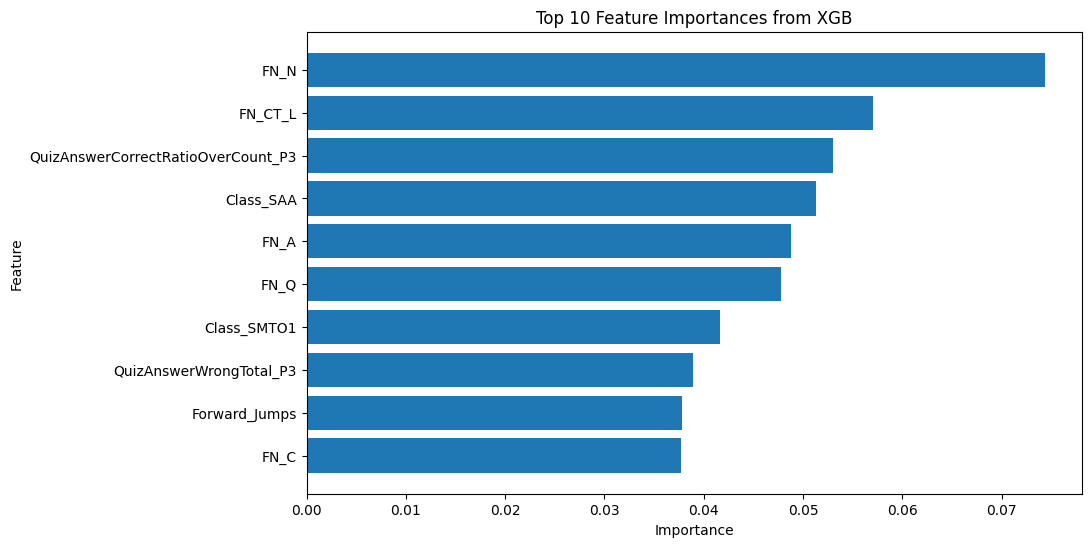

,Feature,Importance
8,FN_N,0.074351
36,FN_CT_L,0.057097
5,QuizAnswerCorrectRatioOverCount_P3,0.053069
29,Class_SAA,0.051347
10,FN_A,0.048789
9,FN_Q,0.047828
32,Class_SMTO1,0.041613
4,QuizAnswerWrongTotal_P3,0.038924
14,Forward_Jumps,0.037848
11,FN_C,0.037758


In [521]:
# XAI
print(">> XAI - Eplaining the model")
feature_importances_df = extract_feature_importances(pipeline, X_train, ml_file, current_date_string, ml_dir, encoding_type, prediction_type)
feature_importances_df.head(10)

### LSTM

In [522]:
# Convert the target labels to start from 0 instead of 1 (LSTM and XGB starts from 0)
# (i.e. if your original labels are 1,2,3, they become 0,1,2)
y = df_prediction[target_variable] - 1

In [523]:
# -------------------------------
# Data Splitting: Create training+validation and test sets (70% for training+validation, 30% for testing)
# -------------------------------
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Further split the training+validation set into training and validation sets (80% for training, 20% for validation)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

# -------------------------------
# Standardise the features using StandardScaler
# -------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# -------------------------------
# Reshape the data for LSTM input
# LSTM models require a 3D input: (samples, timesteps, features).
# Since our data is not sequential, we use 1 time step.
# -------------------------------
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_lstm   = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_lstm  = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# -------------------------------
# Build the LSTM Model
# -------------------------------
n_features = X_train_lstm.shape[2]  # Number of features per time step

model = Sequential()
# model.add(LSTM(64, input_shape=(1, n_features), return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification


model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(1, n_features)))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with binary cross-entropy loss and Adam optimiser
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# -------------------------------
# Train the Model with Early Stopping to keep training times short
# -------------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_lstm, y_train,
    epochs=20,                # Set a low number of epochs; early stopping will help prevent overtraining
    batch_size=32,
    validation_data=(X_val_lstm, y_val),
    callbacks=[early_stop],
    verbose=1
)

# -------------------------------
# Evaluate the Model and Build the Metrics Dictionary
# -------------------------------

# Evaluate on the validation set
val_loss, val_accuracy = model.evaluate(X_val_lstm, y_val, verbose=0)
# Obtain predictions (thresholding at 0.5 for binary classification)
val_pred_probs = model.predict(X_val_lstm)
val_preds = (val_pred_probs > 0.5).astype(int)
# Create a classification report dictionary for validation data
val_report = classification_report(y_val, val_preds, output_dict=True)

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test_lstm, y_test, verbose=0)
test_pred_probs = model.predict(X_test_lstm)
test_preds = (test_pred_probs > 0.5).astype(int)
test_report = classification_report(y_test, test_preds, output_dict=True)

# Create an evaluation dictionary similar to the one for the RandomForest model
evaluation_metrics = {
    'validation': {
         'loss': val_loss,
         'accuracy': val_accuracy,
         'classification_report': val_report
    },
    'test': {
         'loss': test_loss,
         'accuracy': test_accuracy,
         'classification_report': test_report
    }
}

# Print the evaluation metrics dictionary
print(evaluation_metrics)

# Save the classification_report as file
print("> Creating report metrics dataframe")
df_report = save_model_report(report_dict, encoding_type, "LSTM", ml_dir, ml_file, prediction_type, False)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_9 (Bidirectional) │ (None, 1, 256)         │       172,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 258,433 (1009.50 KB)

 Trainable params: 258,433 (1009.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3587 - loss: 0.6391 - val_accuracy: 0.3628 - val_loss: 0.3779
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3662 - loss: 0.2065 - val_accuracy: 0.3628 - val_loss: 0.0297
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3689 - loss: -0.1393 - val_accuracy: 0.3533 - val_loss: -0.2434
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3691 - loss: -1.0119 - val_accuracy: 0.3596 - val_loss: -0.7164
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3694 - loss: -1.7919 - val_accuracy: 0.3628 - val_loss: -1.5271
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3852 - loss: -4.6968 - val_accuracy: 0.3785 - val_loss: -2.6989
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3552 - loss: -7.0110 - val_accuracy: 0.3691 - val_loss: -4.6705
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3625 - loss: -12.8371 - val_accuracy: 0.375

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [524]:
print(evaluation_metrics)

{'validation': {'loss': -74.49439239501953, 'accuracy': 0.37854889035224915, 'classification_report': {'0': {'precision': 0.5909090909090909, 'recall': 0.11304347826086956, 'f1-score': 0.1897810218978102, 'support': 115.0}, '1': {'precision': 0.36271186440677966, 'recall': 0.9304347826086956, 'f1-score': 0.5219512195121951, 'support': 115.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 87.0}, 'accuracy': 0.3785488958990536, 'macro avg': {'precision': 0.31787365177195687, 'recall': 0.34782608695652173, 'f1-score': 0.23724408047000178, 'support': 317.0}, 'weighted avg': {'precision': 0.34595081975181424, 'recall': 0.3785488958990536, 'f1-score': 0.25819939357145305, 'support': 317.0}}}, 'test': {'loss': -144.0868377685547, 'accuracy': 0.36725664138793945, 'classification_report': {'0': {'precision': 0.5217391304347826, 'recall': 0.0975609756097561, 'f1-score': 0.1643835616438356, 'support': 246.0}, '1': {'precision': 0.3560126582278481, 'recall': 0.9146341463414634

# Aggregate the results

In [531]:
df_results_agg = aggregate_csv_results(ml_dir, "csv", "_fimp")
print("Final dataset length:", len(df_results_agg))

File _2025-02-08_ml_AGG_results.csv does not contain the required columns.
Files with extension 'csv' read: 19

Final dataset length: 18

Final dataset length: 18


In [532]:
df_results_agg.head(10)

,ModelName,FieldNotes,Encoding,Avg precision,Avg recall,Avg f1-score
1,LSTM,1,B,0.806,0.795,0.798
13,XGB,1,B,0.806,0.795,0.798
17,XGB,1,I,0.785,0.778,0.781
3,LSTM,1,F,0.783,0.780,0.781
15,XGB,1,F,0.783,0.780,0.781
5,LSTM,1,I,0.785,0.778,0.781
2,LSTM,0,F,0.779,0.771,0.774
14,XGB,0,F,0.779,0.771,0.774
12,XGB,0,B,0.777,0.768,0.771
0,LSTM,0,B,0.777,0.768,0.771


In [534]:
print("> Saving aggregated results")
current_date_string = datetime.now().strftime("%Y-%m-%d")
file_out = f"_{current_date_string}_ml_AGG_results.csv"
path_out = Path(ml_dir) / file_out
print("Saving to:", path_out)
df_results_agg.to_csv(path_out, sep=";", index=False)

> Saving aggregated results
Saving to: data_ml/_2025-02-08_ml_AGG_results.csv


In [535]:
end_time = datetime.now().replace(microsecond=0)
delta_time = end_time - start_time
total_seconds = int(delta_time.total_seconds())
minutes, seconds = divmod(total_seconds, 60)

print()
print("End process")
print("Script finished at:",  datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print(f"Time to finish ({delta_time}): {minutes} minutes, {seconds} seconds")


End process
Script finished at: 2025-02-08 15:08:32
Time to finish (0:08:59): 8 minutes, 59 seconds


In [536]:
print()
print("*** PROGRAM START ***")
print()


*** PROGRAM START ***

